In [2]:
#https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794
#https://wisdomml.in/bag-of-words-bow-model-with-complete-implementation-in-python/
#https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/            
#https://colab.research.google.com/github/goodboychan/goodboychan.github.io/blob/main/_notebooks/2020-07-17-03-N-Gram-models.ipynb
#https://colab.research.google.com/github/PradipNichite/Youtube-Tutorials/blob/main/Youtube_NLP_Text_Representaion.ipynb#scrollTo=rynjIW1f87JV
#https://github.com/hminooei/DSbyHadi/blob/master/Tutorial3/sentiment-analysis-bow.ipynb
#https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/
#https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c
#https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

import json
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
import gensim
import gensim.downloader as gensim_api

data = pd.read_csv('4coldata.csv')
data.drop(['score', 'length'], inplace = True, axis = 1)
data

,y,text
0,0,used app called melody two year app includes b...
1,0,felt reasonably tired bed time got bed closed ...
2,0,hear slept poorly next day luxury
3,0,whenever warm outside bird chirp outside windo...
4,0,mirtazapine remeron past year month ago began ...
...,...,...
18394,1,day many time incredible moodiness overwhelmin...
18395,1,hi everyone new poster sub trying see anyone e...
18396,1,hard time falling asleep exhausted cant switch...
18397,1,anyone else rly want sleep feel tired get anxi...


In [2]:
'''
tf_vectorizer = feature_extraction.text.CountVectorizer(tokenizer=LemmaTokenizer,
max_features=200, ngram_range=(1,3),
                       strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True,
                       max_df = 0.5,
                       min_df = 10)'''

"\ntf_vectorizer = feature_extraction.text.CountVectorizer(tokenizer=LemmaTokenizer,\nmax_features=200, ngram_range=(1,3),\n                       strip_accents = 'unicode',\n                       stop_words = 'english',\n                       lowercase = True,\n                       max_df = 0.5,\n                       min_df = 10)"

In [3]:
data['y'].value_counts()

0    9751
1    8648
Name: y, dtype: int64

In [4]:
# split train dataset into train, validation and test sets

from sklearn.model_selection import train_test_split

X_train, temp_text, y_train, temp_labels = train_test_split(data['text'], data['y'], 
                                                                    random_state=20, 
                                                                    test_size=0.4, 
                                                                    stratify=data['y'])


X_val, X_test, y_val, y_test = train_test_split(temp_text, temp_labels, 
                                                                random_state=20, 
                                                              test_size=0.5, 
                                                              stratify=temp_labels)

In [5]:
'''def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, validate, test =train_validate_test_split(data)

X_train, y_train = train.drop(columns='y').copy(), train['y'].copy()
X_val, y_val = validate.drop(columns='y').copy(), validate['y'].copy()
X_test, y_test = test.drop(columns='y').copy(), test['y'].copy()'''

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(11039,) (11039,) (3680,) (3680,) (3680,) (3680,)


In [6]:
print(y_test.value_counts())
print(y_val.value_counts())
print(y_train.value_counts())

0    1951
1    1729
Name: y, dtype: int64
0    1950
1    1730
Name: y, dtype: int64
0    5850
1    5189
Name: y, dtype: int64


In [9]:
# Dictionary of all words from train corpus with their counts.

corpustrain = X_train.values.astype('U')

wordfreqtrain = {}
for sentence in corpustrain:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreqtrain.keys():
            wordfreqtrain[token] = 1
        else:
            wordfreqtrain[token] += 1
            
wordfreqtrain = {k:v for k,v in wordfreqtrain.items() if v >= 10}
       
DICT_SIZE = 10000
POPULAR_WORDS = sorted(wordfreqtrain, key=wordfreqtrain.get, reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {key: rank for rank, key in enumerate(POPULAR_WORDS, 0)}
INDEX_TO_WORDS = {index:word for word, index in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

In [10]:
# Dictionary of all words from validation corpus with their counts.

corpusval = X_val.values.astype('U')

wordfreqval = {}
for sentence in corpusval:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreqval.keys():
            wordfreqval[token] = 1
        else:
            wordfreqval[token] += 1
            
wordfreqval = {k:v for k,v in wordfreqval.items() if v >= 10}

DICT_SIZE = 10000
POPULAR_WORDSv = sorted(wordfreqval, key=wordfreqval.get, reverse=True)[:DICT_SIZE]
WORDS_TO_INDEXv = {key: rank for rank, key in enumerate(POPULAR_WORDSv, 0)}
INDEX_TO_WORDSv = {index:word for word, index in WORDS_TO_INDEXv.items()}
ALL_WORDSv = WORDS_TO_INDEXv.keys()

In [11]:
# Dictionary of all words from test corpus with their counts.

corpustest = X_test.values.astype('U')

wordfreqtest = {}
for sentence in corpustest:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreqtest.keys():
            wordfreqtest[token] = 1
        else:
            wordfreqtest[token] += 1
            
wordfreqtest = {k:v for k,v in wordfreqtest.items() if v >= 10}

DICT_SIZE = 10000
POPULAR_WORDSt = sorted(wordfreqtest, key=wordfreqtest.get, reverse=True)[:DICT_SIZE]
WORDS_TO_INDEXt = {key: rank for rank, key in enumerate(POPULAR_WORDSt, 0)}
INDEX_TO_WORDSt = {index:word for word, index in WORDS_TO_INDEXt.items()}
ALL_WORDSt = WORDS_TO_INDEXt.keys()

In [12]:
#Find 200 most frequent words for train, validate, test

import heapq

most_freqtrain = heapq.nlargest(200, wordfreqtrain, key=wordfreqtrain.get)
most_freqval = heapq.nlargest(200, wordfreqval, key=wordfreqval.get)
most_freqtest = heapq.nlargest(200, wordfreqtest, key=wordfreqtest.get)
print(type(most_freqtrain), len(most_freqtrain))

<class 'list'> 200


In [8]:
##2#### LET'S DO IT ONE MORE TIME FOR BOW-COUNT n-grams

#max_features: top max_features ordered by term frequency across the corpus 
#max_df=1,

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

#Count (classic BoW)
#Cvectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english', max_df = 0.5, min_df = 10, max_features=200, ngram_range=(1,3))
Cvectorizer = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10, max_features=500, ngram_range=(1,3))
Cvectorizerv = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10,max_features=500, ngram_range=(1,3))
Cvectorizert = feature_extraction.text.CountVectorizer(stop_words = 'english', min_df = 10, max_features=500, ngram_range=(1,3))

#use the vectorizer on the corpus to extract a vocabulary and create the feature matrix.   #max_features=500,

#corpus = data['text'].values.astype('U')
corpustrain = X_train.values.astype('U')
Cvectorizer.fit(corpustrain)
#Cvectorizer.fit(corpus)
X_trainC = Cvectorizer.transform(corpustrain)#.toarray() 
#dic_vocabulary = Cvectorizer.vocabulary_

corpusval = X_val.values.astype('U')
Cvectorizerv.fit(corpusval)
X_valC = Cvectorizerv.transform(corpusval)#.toarray() 
#dic_vocabularyv = Cvectorizerv.vocabulary_

corpustest = X_test.values.astype('U')
Cvectorizert.fit(corpustest)
X_testC = Cvectorizert.transform(corpustest)#.toarray() 
#dic_vocabularyt = Cvectorizert.vocabulary_


namedtrain=pd.DataFrame(X_trainC.toarray(),columns=Cvectorizer.get_feature_names())
namedval=pd.DataFrame(X_valC.toarray(),columns=Cvectorizerv.get_feature_names())
namedtest=pd.DataFrame(X_testC.toarray(),columns=Cvectorizert.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
###CHI-SQUARE FEATURE SELECTION FOR TRAIN SET

X_names = Cvectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y_train):
    chi2, p = feature_selection.chi2(namedtrain, y_train==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()


for cat in np.unique(y_train):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
    print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:]))
    print(" ")
    
    
print(namedtrain.shape)

# 0:
  . selected features: 97
  . top features: benadryl,fuck,use,game,went,hour,bed,aid,hope,health,fear,shit,like,pattern,idk,min,sleep aid,caffeine,drug,new,feel like,job,said,bad,sleep wake,work,happening,brain,ca,night,insomniac,pain,med,blanket,helped,anymore,life,scared,half,fucking,habit,fast,breathing,control,usual,thank,really,sleep schedule,schedule,wake,routine,tomorrow,hit,people,deal,edit,home,room,worst,disorder,small,cbd,afraid,struggle,alarm,feel,struggling,prescription,body,old,ambien,insomnia,dream,starting,le,result,xanax,moment,book,let,sleep sleep,fall asleep,needed,today,pretty,bed hour,believe,felt,year,read,gave,headache,wrong,dark,trazadone,weekend,terrible
 
# 1:
  . selected features: 97
  . top features: benadryl,fuck,use,game,went,hour,bed,aid,hope,health,fear,shit,like,pattern,idk,min,sleep aid,caffeine,drug,new,feel like,job,said,bad,sleep wake,work,happening,brain,ca,night,insomniac,pain,med,blanket,helped,anymore,life,scared,half,fucking,habit,fast,br

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wd/1sxcpd491kg32hysvmfw5d3r0000gn/T/ipykernel_1575/981441397.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_features = dtf_features.append(pd.DataFrame(
/var/folders/wd/1sxcpd491kg32hysvmfw5d3r0000gn/T/ipykernel_1575/981441397.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_features = dtf_features.append(pd.DataFrame(


In [21]:
###CHI-SQUARE FEATURE SELECTION FOR VAL SET

Xv_names = Cvectorizerv.get_feature_names()
p_value_limit = 0.95
dtfv_features = pd.DataFrame()
for cat in np.unique(y_val):
    chi2, p = feature_selection.chi2(namedval, y_val==cat)
    dtfv_features = dtfv_features.append(pd.DataFrame(
                   {"feature":Xv_names, "score":1-p, "y":cat}))
    dtfv_features = dtfv_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtfv_features = dtfv_features[dtfv_features["score"]>p_value_limit]
Xv_names = dtfv_features["feature"].unique().tolist()


for cat in np.unique(y_val):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtfv_features[dtfv_features["y"]==cat]))
    print("  . top features:", ",".join(
dtfv_features[dtfv_features["y"]==cat]["feature"].values[:]))
    print(" ")

# 0:
  . selected features: 71
  . top features: health,class,sleep,tired,ambien,anxiety,struggle,eat,magnesium,issue,sleep feel,matter,open,post,zopiclone,better,psychiatrist,mental,college,fix,late,sleepless night,feel,physically,going,sure,scared,mind,hour day,want,away,type,sleeping,amp,worry,different,kinda,room,shift,anxious,really bad,sleep aid,pain,till,year ago,sorry,ca,seeing,stop,make feel,half,insomnia,experiencing,wide awake,high,light,waking,cycle,wide,need,awake,everyday,memory,past month,state,wondering,earlier,especially,therapist,trying sleep,recently
 
# 1:
  . selected features: 71
  . top features: health,class,sleep,tired,ambien,anxiety,struggle,eat,magnesium,issue,sleep feel,matter,open,post,zopiclone,better,psychiatrist,mental,college,fix,late,sleepless night,feel,physically,going,sure,scared,mind,hour day,want,away,type,sleeping,amp,worry,different,kinda,room,shift,anxious,really bad,sleep aid,pain,till,year ago,sorry,ca,seeing,stop,make feel,half,insomnia,expe

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wd/1sxcpd491kg32hysvmfw5d3r0000gn/T/ipykernel_1575/626381831.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtfv_features = dtfv_features.append(pd.DataFrame(
/var/folders/wd/1sxcpd491kg32hysvmfw5d3r0000gn/T/ipykernel_1575/626381831.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtfv_features = dtfv_features.append(pd.DataFrame(


In [22]:
###CHI-SQUARE FEATURE SELECTION FOR TEST SET

Xt_names = Cvectorizert.get_feature_names()
p_value_limit = 0.95
dtft_features = pd.DataFrame()
for cat in np.unique(y_test):
    chi2, p = feature_selection.chi2(namedtest, y_test==cat)
    dtft_features = dtft_features.append(pd.DataFrame(
                   {"feature":Xt_names, "score":1-p, "y":cat}))
    dtft_features = dtft_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtft_features = dtft_features[dtft_features["score"]>p_value_limit]
Xt_names = dtft_features["feature"].unique().tolist()


for cat in np.unique(y_test):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtft_features[dtft_features["y"]==cat]))
    print("  . top features:", ",".join(
dtft_features[dtft_features["y"]==cat]["feature"].values[:]))
    print(" ")

# 0:
  . selected features: 93
  . top features: life,people,na,wish,insomnia,better,great,sleep aid,job,able sleep,guy,able,deal,maybe,schedule,lot,helped,asleep,causing,ambien,aid,home,relax,wan,wan na,talking,hell,need,related,run,wake,blanket,im,hot,sleep schedule,gon,gon na,fine,way,amp,sleep,make,work,effect,new,seroquel,told,started,eventually,routine,honestly,wide awake,experienced,kind,unable,good,midnight,got,high,med,hospital,sort,drink,yesterday,fall asleep,fall,left,stay asleep,help,wide,year,alcohol,breathing,know,book,supplement,going,lying,solution,mean,phone,coffee,reading,difficult,sure,really,weed,muscle,college,time,happening,food,end
 
# 1:
  . selected features: 93
  . top features: life,people,na,wish,insomnia,better,great,sleep aid,job,able sleep,guy,able,deal,maybe,schedule,lot,helped,asleep,causing,ambien,aid,home,relax,wan,wan na,talking,hell,need,related,run,wake,blanket,im,hot,sleep schedule,gon,gon na,fine,way,amp,sleep,make,work,effect,new,seroquel,told,s

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wd/1sxcpd491kg32hysvmfw5d3r0000gn/T/ipykernel_1575/1598991110.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtft_features = dtft_features.append(pd.DataFrame(
/var/folders/wd/1sxcpd491kg32hysvmfw5d3r0000gn/T/ipykernel_1575/1598991110.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtft_features = dtft_features.append(pd.DataFrame(


In [16]:
#Let's see the common features for train, val, and test without CHI-SQUARE

print(len(list(namedtrain.columns)), len(list(namedval.columns)), len(list(namedtest.columns)))
trainval = pd.concat([namedtrain, namedval], axis=0, join = 'inner')
three = pd.concat([trainval, namedtest], axis=0, join = 'inner')
print(three.shape)

comcol = three.columns
len(comcol)
#namedtrain[comcol] 
#9868 3419 3481 >> (18399, 2857)

500 500 500
(18399, 453)


453

In [17]:
#Let's see the common features for train, val, and test AFTER CHI-SQUARE

print(len(X_names), len(Xv_names), len(Xt_names))
trainvalnames = pd.concat([namedtrain[X_names], namedval[Xv_names]], axis=0, join = 'inner')
threenames = pd.concat([trainvalnames, namedtest[Xt_names]], axis=0, join = 'inner')
print(threenames.shape)
print(threenames.columns)

NameError: name 'X_names' is not defined

In [8]:
print(len(list(namedtrain.columns)), len(list(namedval.columns)), len(list(namedtest.columns)))
trainval = set(list(namedtrain.columns)).intersection(list(namedval.columns))
traintest = set(list(namedtrain.columns)).intersection(list(namedtest.columns))
valtest = set(list(namedval.columns)).intersection(list(namedtest.columns))
three = set(list(trainval)).intersection(list(namedtest.columns))
print(len(trainval), len(traintest),len(valtest),len(three))
#191 192 192 187
#9868 3419 3481. > 3406 3466 2857 2857

200 200 200
191 192 190 187


In [9]:
print(namedtrain.columns[:100]) #n grams

Index(['able', 'able sleep', 'actually', 'advice', 'ago', 'ambien', 'anxiety',
       'anxious', 'anymore', 'asleep', 'awake', 'away', 'bad', 'bed', 'best',
       'better', 'bit', 'body', 'brain', 'ca', 'ca sleep', 'cause', 'come',
       'completely', 'couple', 'currently', 'cycle', 'day', 'depression',
       'different', 'doctor', 'dont', 'dream', 'drink', 'drug', 'early',
       'effect', 'end', 'exercise', 'exhausted', 'experience', 'eye', 'fall',
       'fall asleep', 'falling', 'falling asleep', 'feel', 'feel like',
       'feeling', 'felt', 'finally', 'fine', 'friend', 'fucking', 'getting',
       'going', 'good', 'got', 'gotten', 'great', 'guy', 'half', 'happen',
       'happened', 'happens', 'hard', 'head', 'health', 'heart', 'help',
       'helped', 'hi', 'home', 'hope', 'hour', 'hour night', 'hour sleep',
       'idea', 'im', 'insomnia', 'issue', 'job', 'kind', 'know', 'late',
       'later', 'lay', 'le', 'let', 'life', 'light', 'like', 'literally',
       'little', 'long'

In [9]:
## 3 ####. Tf-Idf (advanced variant of BoW)

#vectorizer = feature_extraction.text.TfidfVectorizer(max_features=200, ngram_range=(1,3))

vectorizer = feature_extraction.text.TfidfVectorizer(stop_words = 'english', max_features=500, min_df = 10, ngram_range=(1,3))
vectorizerv = feature_extraction.text.TfidfVectorizer(stop_words = 'english', max_features=500,min_df = 10, ngram_range=(1,3))
vectorizert = feature_extraction.text.TfidfVectorizer(stop_words = 'english',max_features=500, min_df = 10, ngram_range=(1,3))
#10000

#use the TF-IDF vectorizer on the corpus to extract a vocabulary and create the 
#feature matrix.

vectorizer.fit(corpustrain)
X_traintfidf= vectorizer.transform(corpustrain)#.toarray() 
tfidftrain = pd.DataFrame(X_traintfidf.todense())

vectorizerv.fit(corpusval)
X_valtfidf= vectorizerv.transform(corpusval)#.toarray() 
tfidfval = pd.DataFrame(X_valtfidf.todense())

vectorizert.fit(corpustest)
X_testtfidf= vectorizert.fit_transform(corpustest)#.toarray() 
tfidftest = pd.DataFrame(X_testtfidf.todense())

tfidftrain=pd.DataFrame(X_traintfidf.toarray(),columns=vectorizer.get_feature_names())
tfidfval=pd.DataFrame(X_valtfidf.toarray(),columns=vectorizerv.get_feature_names())
tfidftest=pd.DataFrame(X_testtfidf.toarray(),columns=vectorizert.get_feature_names())

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
tfidftrain

,able,able fall,able fall asleep,able sleep,absolutely,actually,advice,affect,afraid,ago,...,worried,worry,worse,worst,wrong,xanax,year,year ago,year old,yesterday
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.158881,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.225683,0.058071,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.089493,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.093352,0.000000,0.0,0.0,0.000000,0.105931,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11034,0.0,0.0,0.0,0.0,0.0,0.068284,0.141832,0.0,0.0,0.0,...,0.0,0.000000,0.067168,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
11035,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
11036,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
11037,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


Text(0.5, 1.0, 'Sparse Matrix Count Vectorizer')

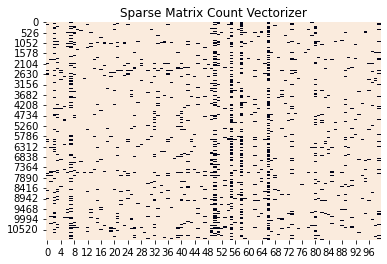

In [31]:
#for Cvectorizer
sns.heatmap(X_trainC.todense()[:,np.random.randint(0,X_trainC.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Count Vectorizer')

Text(0.5, 1.0, 'Sparse Matrix Tf-idf')

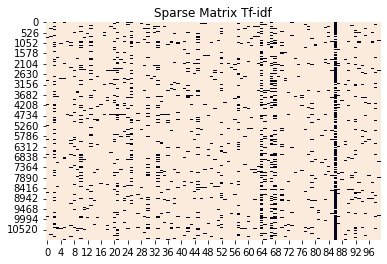

In [11]:
sns.heatmap(X_traintfidf.todense()[:,np.random.randint(0,X_traintfidf.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Tf-idf')

In [ ]:
'''grid_search(stop_words_list=['english', None], ngram_ranges_list=[(1,2), (1,3)], max_features_list=[2000, 5000, 60000],,
            norm_list=['l2', 'l1'], use_idf_list=[True, False],
            penalty_list=['l1', 'l2'], C_list=[.01, 0.07, 0.1, 0.2, 0.9])'''

In [12]:
print(len(list(namedtrain.columns)), len(list(namedval.columns)), len(list(namedtest.columns)))
trainval = set(list(namedtrain.columns)).intersection(list(namedval.columns))
traintest = set(list(namedtrain.columns)).intersection(list(namedtest.columns))
valtest = set(list(namedval.columns)).intersection(list(namedtest.columns))
three = set(list(trainval)).intersection(list(namedtest.columns))
print(len(trainval), len(traintest),len(valtest),len(three))

500 500 500
469 468 464 453


In [13]:
namedval

,able,able fall,able fall asleep,able sleep,absolutely,actually,advice,afraid,ago,aid,...,worry,worse,worst,wrong,xanax,year,year ago,year old,yesterday,zopiclone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3677,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
namedval.shape

(3680, 500)

 Accuracy: 0.5404891304347826
Precision: 0.5325542570951586
 Recall: 0.18439306358381502
 F1: 0.2739373121511378


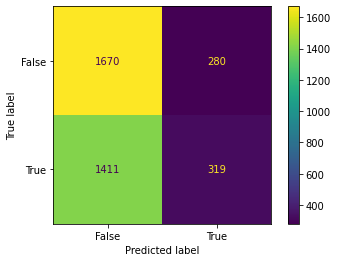

'Accuracy: 0.5390051644468605\nPrecision: 0.5100864553314121\n Recall: 0.20701754385964913 \n F1: 0.2945091514143095\n 200 features'

In [16]:
###For n-gram BoW features  #with x common features for all three sets

from sklearn.svm import SVC, LinearSVC
from sklearn import metrics

model = SVC(C = 1.0, kernel='linear')
#(C=1.0, kernel='linear', degree=3, gamma='auto')
model.fit(namedtrain[comcol],y_train) 
predicted = model.predict(namedval[comcol])  #predict on validation set :)

print(" Accuracy:",metrics.accuracy_score(y_val, predicted))
print("Precision:",metrics.precision_score(y_val, predicted))
print(" Recall:",metrics.recall_score(y_val, predicted))
print(" F1:",metrics.f1_score(y_val, predicted))

confusion_matrix = metrics.confusion_matrix(y_val, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()


''' Accuracy: 0.5392769774395216
Precision: 0.5064599483204134
 Recall: 0.34385964912280703
 F1: 0.4096133751306165
 500 features
 '''

'''Accuracy: 0.5390051644468605
Precision: 0.5100864553314121
 Recall: 0.20701754385964913 
 F1: 0.2945091514143095
 200 features'''

 Accuracy: 0.5527173913043478
Precision: 0.530791788856305
 Recall: 0.4184971098265896
 F1: 0.4680025856496445


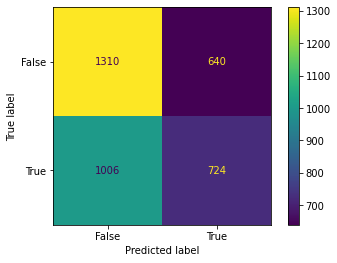

'Accuracy: 0.5442934782608696\nPrecision: 0.5228251507321274\n Recall: 0.3508670520231214\n F1: 0.41992390176409544\n 200 feature\n '

In [18]:
##TF-IDF features 

from sklearn.svm import SVC, LinearSVC
from sklearn import metrics

model = SVC(C = 1.0, kernel='linear')
#(C=1.0, kernel='linear', degree=3, gamma='auto')
model.fit(tfidftrain[comcol],y_train) 
predicted = model.predict(tfidfval[comcol])  #predict on validation set :)

print(" Accuracy:",metrics.accuracy_score(y_val, predicted))
print("Precision:",metrics.precision_score(y_val, predicted))
print(" Recall:",metrics.recall_score(y_val, predicted))
print(" F1:",metrics.f1_score(y_val, predicted))

confusion_matrix = metrics.confusion_matrix(y_val, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()


'''Accuracy: 0.5442934782608696
Precision: 0.5228251507321274
 Recall: 0.3508670520231214
 F1: 0.41992390176409544
 200 feature
 '''

'''Accuracy: 0.5527173913043478
Precision: 0.530791788856305
 Recall: 0.4184971098265896
 F1: 0.4680025856496445
 500 feature
 '''

In [19]:
namedtrain.shape

(11039, 500)

In [28]:
'''#For n-gram BoW features

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': [0.1, 1, 10]}
  
grid = GridSearchCV(SVC(kernel = 'linear'), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(namedtrain,y_train)

#The ‘l2’ penalty is the standard used in SVC. 
#  'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
# 1000, 100'''

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............................C=0.1;, score=0.534 total time=   8.6s
[CV 2/5] END .............................C=0.1;, score=0.555 total time=   8.3s
[CV 3/5] END .............................C=0.1;, score=0.539 total time=   8.3s
[CV 4/5] END .............................C=0.1;, score=0.544 total time=   8.5s
[CV 5/5] END .............................C=0.1;, score=0.522 total time=   8.7s
[CV 1/5] END ...............................C=1;, score=0.534 total time=  16.8s
[CV 2/5] END ...............................C=1;, score=0.553 total time=  17.7s
[CV 3/5] END ...............................C=1;, score=0.540 total time=  17.4s
[CV 4/5] END ...............................C=1;, score=0.543 total time=  17.1s
[CV 5/5] END ...............................C=1;, score=0.527 total time=  16.8s
[CV 1/5] END ..............................C=10;, score=0.535 total time= 2.2min
[CV 2/5] END ..............................C=10;,

GridSearchCV(estimator=SVC(kernel='linear'), param_grid={'C': [0.1, 1, 10]},
             verbose=3)

In [29]:
'''# print best parameter after tuning
print(grid.best_params_)
#{'C': 10}

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)'''

{'C': 10}
SVC(C=10, kernel='linear')


In [20]:
# combine train and validate sets for shared features

print('namedtrain shape:', namedtrain.shape, 'namedval shape:', namedval.shape)
X_train = pd.concat([namedtrain[comcol], namedval[comcol]], axis=0, join = 'inner')
X_traintfidf = pd.concat([tfidftrain[comcol], tfidfval[comcol]], axis=0, join = 'inner')
print('X_train shape:', X_train.shape)
#X_train.columns = [''] * len(X_train.columns)
Y_train = pd.concat([y_train, y_val], axis=0)
print('Y_train shape:', Y_train.shape, 'y_train shape:', y_train.shape, 'y_val shape:', y_val.shape)

namedtrain shape: (11039, 500) namedval shape: (3680, 500)
X_train shape: (14719, 453)
Y_train shape: (14719,) y_train shape: (11039,) y_val shape: (3680,)


In [21]:
X_test = namedtest[comcol]
#X_test.columns = [''] * len(namedtest[comcol].columns)
X_test

,able,able fall,able fall asleep,able sleep,absolutely,actually,advice,afraid,ago,aid,...,worried,worry,worse,worst,wrong,xanax,year,year ago,year old,yesterday
0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
1,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3677,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3678,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


 Accuracy: 0.5366847826086957
Precision: 0.5214285714285715
 Recall: 0.16888374783111626
 F1: 0.25513324595893405


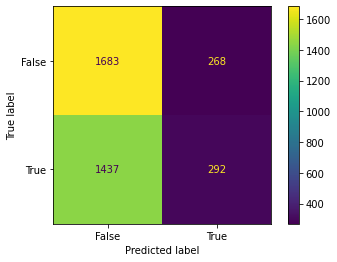

'\nAccuracy: 0.5490355881553926\nPrecision: 0.5347593582887701\n Recall: 0.17657445556209536\n F1: 0.2654867256637168\n200 features\n'

In [22]:
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics

model2 = SVC(C = 10, kernel='linear')
model2.fit(X_train,Y_train) 
predicted = model2.predict(X_test)  #predict on test set :)

print(" Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print(" Recall:",metrics.recall_score(y_test, predicted))
print(" F1:",metrics.f1_score(y_test, predicted))


confusion_matrix = metrics.confusion_matrix(y_test, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

''' Accuracy: 0.5395273023634882
Precision: 0.5021141649048626
 Recall: 0.279576221306651
 F1: 0.3591682419659735
 500 features
 '''

'''
Accuracy: 0.5490355881553926
Precision: 0.5347593582887701
 Recall: 0.17657445556209536
 F1: 0.2654867256637168
200 features
'''

In [22]:
X_traintfidf.shape
tfidftest[comcol].shape

(3680, 453)

 Accuracy: 0.5475543478260869
Precision: 0.5229885057471264
 Recall: 0.42105263157894735
 F1: 0.4665171419416853


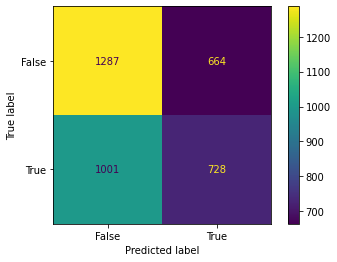

In [23]:
## TF-IDF feature

model2 = SVC(C = 10, kernel='linear')
model2.fit(X_traintfidf,Y_train) 
predicted = model2.predict(tfidftest[comcol])  #predict on test set :)

print(" Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Precision:",metrics.precision_score(y_test, predicted))
print(" Recall:",metrics.recall_score(y_test, predicted))
print(" F1:",metrics.f1_score(y_test, predicted))


confusion_matrix = metrics.confusion_matrix(y_test, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [24]:
X_train.shape

(14719, 453)

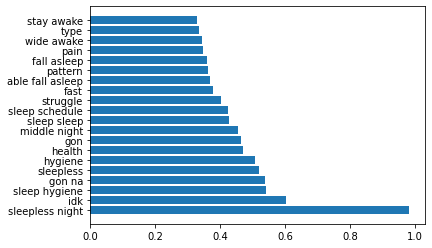

In [43]:
#https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
feature_names = list(X_train.columns)
svm = svm.SVC(kernel='linear', C= 1.0)
svm.fit(X_train, Y_train)    ### TRAIN + VAL SET COMBINED  ##500 max feature

# Specify your top n features you want to visualize.
# You can also discard the abs() function if you are interested in negative contribution
#of features
f_importances(abs(svm.coef_[0]), feature_names, top=20)

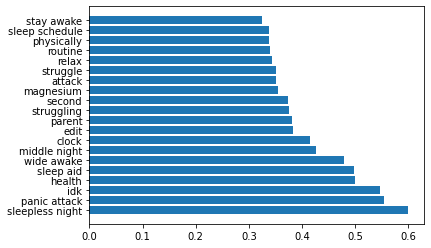

In [39]:
from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
feature_names = list(X_train.columns)
svm = svm.SVC(kernel='linear', C= 1.0)
svm.fit(X_train, Y_train)    ### TRAIN + VAL SET COMBINED  ##200 max feature

# Specify your top n features you want to visualize.
# You can also discard the abs() function if you are interested in negative contribution
#of features
f_importances(abs(svm.coef_[0]), feature_names, top=20)

In [40]:
namedtrain[comcol].shape

(11039, 452)